# Projet : Réduction de dimensionnalité et régression sur données agricoles
Ce notebook suit le cahier des charges : ACP, régression linéaire, et exploitation GPU sur les données fournies.

In [1]:
# Import des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

In [2]:
# Correction avancée du chargement CSV : header absent ou mal lu
data_dir = "data"
file1 = os.path.join(data_dir, "donnees_agro_part1.csv")
file2 = os.path.join(data_dir, "donnees_agro_part2.csv")


def load_and_fix_csv(path):
    # Charge sans header, puis split la colonne unique
    raw = pd.read_csv(path, header=None)
    # La première ligne contient les noms de colonnes
    columns = raw.iloc[0, 0].split(";")
    data = raw.iloc[1:, 0].str.split(";", expand=True)
    data.columns = columns
    return data


df1 = load_and_fix_csv(file1)
df2 = load_and_fix_csv(file2)
df = pd.concat([df1, df2], ignore_index=True)
print(f"Shape du DataFrame corrigé : {df.shape}")
print("Colonnes du DataFrame :", list(df.columns))
df.head()

Shape du DataFrame corrigé : (2000000, 10)
Colonnes du DataFrame : ["Dose d'engrais (kg/ha)", "Heures d'ensoleillement (h/j)", "Volume d'eau (mm/sem)", 'Température (°C)', 'Humidité (%)', 'Types de nutriments', 'Rendement (kg)', 'Taille des fruits (mm)', 'Teneur en solides solubles (Brix)', 'Niveau de défauts (%)']


,Dose d'engrais (kg/ha),Heures d'ensoleillement (h/j),Volume d'eau (mm/sem),Température (°C),Humidité (%),Types de nutriments,Rendement (kg),Taille des fruits (mm),Teneur en solides solubles (Brix),Niveau de défauts (%)
0,232.19,13.39,24.22,27.67,64.81,Organique,9822.03,71.98,15.06,4.25
1,131.66,13.48,23.51,24.70,74.50,Organique,9136.39,69.38,15.31,1.28
2,257.58,9.36,52.08,20.63,69.26,Micro-éléments,9961.21,74.37,10.52,1.26
3,209.21,6.51,34.66,7.12,54.77,Organique,2964.90,61.01,11.88,5.65
4,28.25,11.39,45.60,28.15,69.90,NPK_10-10-10,8313.76,59.00,13.21,3.18


In [3]:
# Conversion des colonnes numériques en float
num_cols = [col for col in df.columns if col != 'Types de nutriments']
for col in num_cols:
    df[col] = df[col].str.replace(',', '.').astype(float)

# Vérification des types
print(df.dtypes)
df.head()

Dose d'engrais (kg/ha)               float64
Heures d'ensoleillement (h/j)        float64
Volume d'eau (mm/sem)                float64
Température (°C)                     float64
Humidité (%)                         float64
Types de nutriments                   object
Rendement (kg)                       float64
Taille des fruits (mm)               float64
Teneur en solides solubles (Brix)    float64
Niveau de défauts (%)                float64
dtype: object


,Dose d'engrais (kg/ha),Heures d'ensoleillement (h/j),Volume d'eau (mm/sem),Température (°C),Humidité (%),Types de nutriments,Rendement (kg),Taille des fruits (mm),Teneur en solides solubles (Brix),Niveau de défauts (%)
0,232.19,13.39,24.22,27.67,64.81,Organique,9822.03,71.98,15.06,4.25
1,131.66,13.48,23.51,24.70,74.50,Organique,9136.39,69.38,15.31,1.28
2,257.58,9.36,52.08,20.63,69.26,Micro-éléments,9961.21,74.37,10.52,1.26
3,209.21,6.51,34.66,7.12,54.77,Organique,2964.90,61.01,11.88,5.65
4,28.25,11.39,45.60,28.15,69.90,NPK_10-10-10,8313.76,59.00,13.21,3.18


In [4]:
# Affichage d'un résumé des colonnes et des types de données
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Dose d'engrais (kg/ha)             float64
 1   Heures d'ensoleillement (h/j)      float64
 2   Volume d'eau (mm/sem)              float64
 3   Température (°C)                   float64
 4   Humidité (%)                       float64
 5   Types de nutriments                object 
 6   Rendement (kg)                     float64
 7   Taille des fruits (mm)             float64
 8   Teneur en solides solubles (Brix)  float64
 9   Niveau de défauts (%)              float64
dtypes: float64(9), object(1)
memory usage: 152.6+ MB


,Dose d'engrais (kg/ha),Heures d'ensoleillement (h/j),Volume d'eau (mm/sem),Température (°C),Humidité (%),Types de nutriments,Rendement (kg),Taille des fruits (mm),Teneur en solides solubles (Brix),Niveau de défauts (%)
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2000000,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
unique,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NPK_10-10-10,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,360162,NaN,NaN,NaN,NaN
mean,1.500265e+02,9.001906e+00,3.001106e+01,2.199828e+01,5.997619e+01,NaN,7.537932e+03,6.421338e+01,1.280930e+01,3.953374e+00
std,8.659556e+01,2.886846e+00,1.731429e+01,5.976767e+00,1.732406e+01,NaN,1.762785e+03,6.401907e+00,1.715481e+00,1.977118e+00
min,0.000000e+00,4.000000e+00,0.000000e+00,5.000000e+00,3.000000e+01,NaN,0.000000e+00,4.057000e+01,5.980000e+00,0.000000e+00
25%,7.499000e+01,6.500000e+00,1.502000e+01,1.795000e+01,4.498000e+01,NaN,6.482960e+03,5.948000e+01,1.159000e+01,2.560000e+00
50%,1.500600e+02,9.000000e+00,3.001000e+01,2.200000e+01,5.997000e+01,NaN,7.654205e+03,6.422000e+01,1.281000e+01,3.920000e+00
75%,2.250200e+02,1.150000e+01,4.501000e+01,2.604000e+01,7.498000e+01,NaN,8.752163e+03,6.894000e+01,1.403000e+01,5.290000e+00


# 1. Préparation des données

## 1.1 Séparation des variables explicatives (X) et des variables cibles (Y)

- **Variables explicatives (X)** : Dose d'engrais, heures d'ensoleillement, volume d'eau, température, humidité, types de nutriments
- **Variables cibles (Y)** : Rendement (kg), taille des fruits, teneur en solides solubles (Brix), niveau de défauts

On sépare les variables selon le cahier des charges.

In [5]:
# Sélection des variables explicatives et cibles avec les bons noms
X_cols = [
    "Dose d'engrais (kg/ha)",
    "Heures d'ensoleillement (h/j)",
    "Volume d'eau (mm/sem)",
    "Température (°C)",
    "Humidité (%)",
    "Types de nutriments",
]
Y_cols = [
    "Rendement (kg)",
    "Taille des fruits (mm)",
    "Teneur en solides solubles (Brix)",
    "Niveau de défauts (%)",
]

X = df[X_cols]
Y = df[Y_cols]
print("Variables explicatives (X) :", X.columns.tolist())
print("Variables cibles (Y) :", Y.columns.tolist())
X.head(), Y.head()

Variables explicatives (X) : ["Dose d'engrais (kg/ha)", "Heures d'ensoleillement (h/j)", "Volume d'eau (mm/sem)", 'Température (°C)', 'Humidité (%)', 'Types de nutriments']
Variables cibles (Y) : ['Rendement (kg)', 'Taille des fruits (mm)', 'Teneur en solides solubles (Brix)', 'Niveau de défauts (%)']


(   Dose d'engrais (kg/ha)  Heures d'ensoleillement (h/j)  \
 0                  232.19                          13.39   
 1                  131.66                          13.48   
 2                  257.58                           9.36   
 3                  209.21                           6.51   
 4                   28.25                          11.39   
 
    Volume d'eau (mm/sem)  Température (°C)  Humidité (%) Types de nutriments  
 0                  24.22             27.67         64.81           Organique  
 1                  23.51             24.70         74.50           Organique  
 2                  52.08             20.63         69.26      Micro-éléments  
 3                  34.66              7.12         54.77           Organique  
 4                  45.60             28.15         69.90        NPK_10-10-10  ,
    Rendement (kg)  Taille des fruits (mm)  Teneur en solides solubles (Brix)  \
 0         9822.03                   71.98                            

## 1.2 Standardisation des variables explicatives

L'ACP est sensible à l'échelle des variables. On applique donc une standardisation (centrage-réduction) sur X.

In [6]:
# Séparation des variables numériques et catégorielles
X_num = X.drop(columns=["Types de nutriments"])
X_cat = X[["Types de nutriments"]]

# Standardisation des variables numériques uniquement
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=X_num.columns)

# On peut ensuite concaténer avec la variable catégorielle si besoin
X_scaled_df = pd.concat([X_num_scaled_df, X_cat.reset_index(drop=True)], axis=1)
X_scaled_df.head()

,Dose d'engrais (kg/ha),Heures d'ensoleillement (h/j),Volume d'eau (mm/sem),Température (°C),Humidité (%),Types de nutriments
0,0.948819,1.520031,-0.334467,0.948962,0.279023,Organique
1,-0.212096,1.551207,-0.375474,0.452037,0.838361,Organique
2,1.242021,0.124043,1.274609,-0.228933,0.535892,Micro-éléments
3,0.683447,-0.863193,0.268503,-2.489353,-0.300518,Organique
4,-1.406268,0.827233,0.900352,1.029273,0.572834,NPK_10-10-10


# 2. Analyse en Composantes Principales (ACP)

## 2.1 Application de l’ACP sur les variables explicatives standardisées

On applique l’ACP sur X standardisé pour réduire la dimensionnalité et visualiser la variance expliquée.

In [7]:
# Application de l’ACP uniquement sur les variables numériques standardisées
pca = PCA()
X_pca = pca.fit_transform(X_num_scaled_df)

# Variance expliquée par chaque composante
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# Affichage
print("Variance expliquée par chaque composante :", explained_var)
print("Variance expliquée cumulée :", cum_explained_var)

Variance expliquée par chaque composante : [0.20054285 0.20015053 0.19992324 0.19976449 0.19961889]
Variance expliquée cumulée : [0.20054285 0.40069338 0.60061662 0.80038111 1.        ]


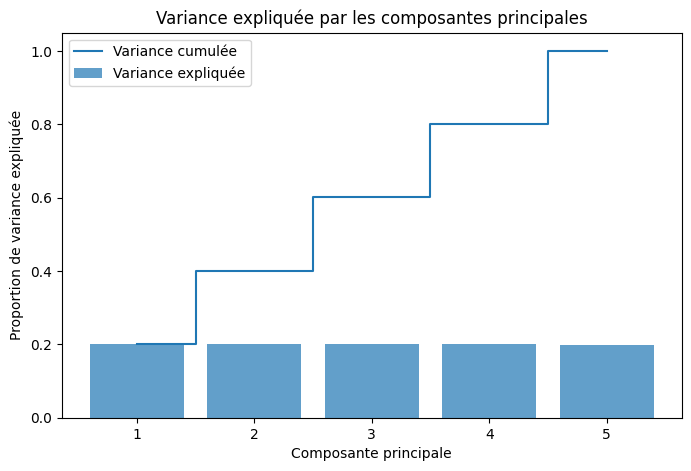

In [8]:
# Visualisation de la variance expliquée
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, label='Variance expliquée')
plt.step(range(1, len(cum_explained_var)+1), cum_explained_var, where='mid', label='Variance cumulée')
plt.xlabel('Composante principale')
plt.ylabel('Proportion de variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.legend()
plt.show()

## 2.2 Sélection du nombre de composantes principales

On retient le nombre de composantes expliquant au moins 95% de la variance totale.

In [9]:
# Nombre de composantes pour 95% de variance
n_components_95 = np.argmax(cum_explained_var >= 0.95) + 1
print(f"Nombre de composantes principales pour >=95% de variance : {n_components_95}")

Nombre de composantes principales pour >=95% de variance : 5


## 2.3 Transformation des données d’origine en un ensemble réduit

On transforme X standardisé en un nouveau jeu de données réduit, composé des composantes principales retenues.

In [10]:
# Transformation des données selon le nombre de composantes retenues (uniquement numériques)
pca_final = PCA(n_components=n_components_95)
X_reduced = pca_final.fit_transform(X_num_scaled_df)

# DataFrame des composantes principales
X_reduced_df = pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(n_components_95)])
X_reduced_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.514203,1.298026,0.015048,1.430656,0.552016
1,-0.117429,1.247618,-0.455193,1.139958,-0.649885
2,-1.335620,0.837980,0.241116,-0.836331,0.527772
3,-1.364189,-1.400281,1.319369,-1.151025,-0.827101
4,0.451164,0.947745,-1.910505,-0.020695,-0.328409


## 2.4 Visualisations et interprétations de l’ACP

On réalise les principaux graphiques d’ACP et on interprète les résultats.

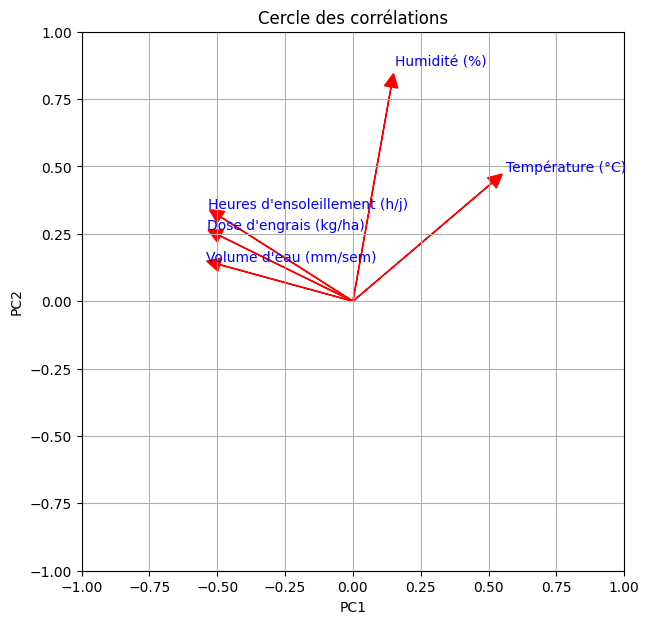

In [11]:
# Cercle des corrélations (variables numériques sur les deux premiers axes)
plt.figure(figsize=(7, 7))
for i, col in enumerate(X_num.columns):
    plt.arrow(
        0,
        0,
        pca_final.components_[0, i],
        pca_final.components_[1, i],
        head_width=0.05,
        head_length=0.05,
        fc="r",
        ec="r",
    )
    plt.text(
        pca_final.components_[0, i] * 1.1,
        pca_final.components_[1, i] * 1.1,
        col,
        color="b",
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cercle des corrélations")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()

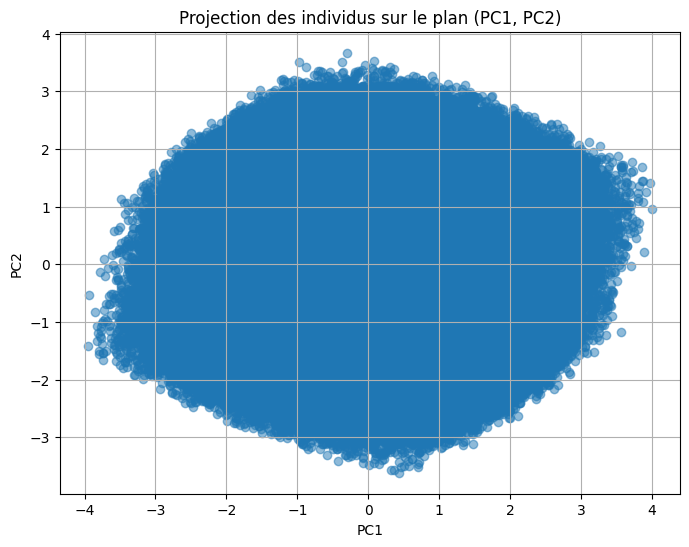

In [12]:
# Projection des individus sur les deux premiers axes
plt.figure(figsize=(8,6))
plt.scatter(X_reduced_df.iloc[:,0], X_reduced_df.iloc[:,1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection des individus sur le plan (PC1, PC2)')
plt.grid()
plt.show()

# 3. Régression linéaire multivariée sur les composantes principales
 
Nous allons utiliser les composantes principales retenues comme variables explicatives pour prédire les variables cibles via une régression linéaire multivariée.

In [13]:
# Séparation en jeu d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_df, Y, test_size=0.2, random_state=42)
print(f"Taille du jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}")

Taille du jeu d'entraînement : (1600000, 5)
Taille du jeu de test : (400000, 5)


### Exemple : Régression linéaire multivariée avec PyTorch (CPU/GPU automatique)
PyTorch permet d’utiliser le GPU si disponible, sinon le CPU. Voici comment entraîner une régression linéaire multivariée avec PyTorch.

In [14]:

import torch
import torch.nn as nn
import torch.optim as optim

# Choix du device (GPU si dispo, sinon CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device utilisé :', device)

# Conversion des données en tenseurs torch
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32).to(device)
Y_train_torch = torch.tensor(Y_train.values, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Définition du modèle linéaire
class LinearRegressionTorch(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        return self.linear(x)

model = LinearRegressionTorch(X_train.shape[1], Y_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraînement
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, Y_train_torch)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

# Prédiction
model.eval()
with torch.no_grad():
    Y_pred_torch = model(X_test_torch).cpu().numpy()
print("Prédictions PyTorch sur le jeu de test :")
print(Y_pred_torch[:5])

Device utilisé : cpu
Epoch 1/500, Loss: 14986138.0000
Epoch 100/500, Loss: 14980851.0000
Epoch 200/500, Loss: 14975517.0000
Epoch 300/500, Loss: 14970192.0000
Epoch 400/500, Loss: 14964870.0000
Epoch 500/500, Loss: 14959557.0000
Prédictions PyTorch sur le jeu de test :
[[18.33456     6.2996593   4.4290476   2.5244284 ]
 [ 7.9367447  -0.74667597  3.9909515   3.8374116 ]
 [ 1.3606708   5.127211    3.794651    2.509538  ]
 [19.425007    2.7337701   4.8072762   3.4299855 ]
 [-8.151384    3.6660745   3.7163675   2.9571185 ]]


In [15]:
# Entraînement du modèle de régression linéaire multivariée
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print("Prédictions sur le jeu de test :")
print(Y_pred[:5])

Prédictions sur le jeu de test :
[[8.83367648e+03 6.73508002e+01 1.28980210e+01 3.30654983e+00]
 [7.35175744e+03 5.72630285e+01 1.24676621e+01 4.62025560e+00]
 [7.03807138e+03 6.36577629e+01 1.22806630e+01 3.29324081e+00]
 [8.76628657e+03 6.24020309e+01 1.32718841e+01 4.21170232e+00]
 [5.89024786e+03 6.31226165e+01 1.21988208e+01 3.74048489e+00]]
